# Laboratorium 6 

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import svm
from sklearn.datasets import make_gaussian_quantiles
import seaborn as sns; sns.set()
import itertools
import nltk
import scipy
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from collections import Counter
from copy import deepcopy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/justyna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wczytanie zbioru danych SMS Spam Collection (formatowanie i etykietyzacja)

In [228]:
datah = []
datas = []
with open('SMSSpamCollection', 'r') as fp:
    lines = fp.read().splitlines()
    for line in lines:
        if line[:4] == 'spam':
            datas.append(line[5:])
        elif line[:3] == 'ham':
            datah.append(line[4:])

In [229]:
spamlabels = np.ones(len(datas)) # etykieta dla spamu = 1
hamlabels = np.zeros(len(datah)) # etykieta dla wiadomosci = 0 

In [230]:
d1 = {'label': spamlabels, 'text': datas}
df = pd.DataFrame(d1)
d2 = {'label': hamlabels, 'text': datah}
df2 = pd.DataFrame(d2)
frames = [df, df2]
data = pd.concat(frames)

In [231]:
data.shape

(5574, 2)

Proporcja klas w zbiorze

In [232]:
print("Ilość wiadomości typu spam:",len(spamlabels),'ilość wiadomośći normalnych:',len(hamlabels))
print('procentowy udział spamu:',(len(spamlabels)/(len(spamlabels)+len(hamlabels)))*100,'%')

Ilość wiadomości typu spam: 747 ilość wiadomośći normalnych: 4827
procentowy udział spamu: 13.40150699677072 %


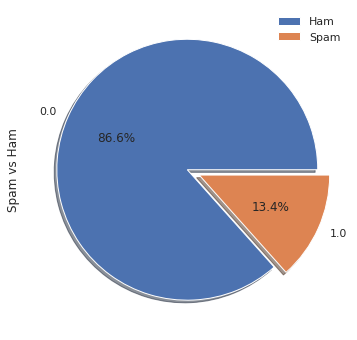

In [233]:
data["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

czy wszystkie wiadomości są unikatowe? Jeżeli nie, jakie wiadomości najczęściej występują w każdej z klas? Czy jakaś wiadomość występuje w obu klasach?

In [234]:
def is_repeated(list1, list2):
    repetition = []
    for i in range(len(list1)):
        for j in range(len(list2)):
            if list1[i] is list2[j]:
                repetition.append(list1[i])
    return set(repetition)

In [235]:
if len(set(data['text'])) is len(data['text']):
    print('Wszystkie wiadomości są unikatowe')
else:
    print("Wiadomości się powtarzają")
#     most_freq_s = (data['text'][data.label == 1]).value_counts()
#     most_freq_h = (data['text'][data.label == 0]).value_counts()
    most_freq_s = data['text'][data.label == 1].mode()
    most_freq_h = data['text'][data.label == 0].mode()
    print('najczęściej występują w spamie', most_freq_s.to_numpy())
    print('najczęściej występują w spamie', most_freq_h.to_numpy())

    powtorzone = is_repeated(data['text'][data.label == 1],data['text'][data.label == 0])
    if not powtorzone:
        print("Brak takich samych wiadomości w obu klasach")
    print(powtorzone)

Wiadomości się powtarzają
najczęściej występują w spamie ['Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!']
najczęściej występują w spamie ["Sorry, I'll call later"]
Brak takich samych wiadomości w obu klasach
set()


Określenie długości wiadomości

In [236]:
data['length'] = data['text'].apply(len)
data.sort_values(by = "length", ascending = False)

,label,text,length
921,0.0,For me the love should start with attraction.i...,910
1603,0.0,The last thing i ever wanted to do was hurt yo...,790
2094,0.0,Indians r poor but India is not a poor country...,629
1355,0.0,How to Make a girl Happy? It's not at all diff...,611
1856,0.0,Sad story of a Man - Last week was my b'day. M...,588
...,...,...,...
1878,0.0,Ok.,3
3893,0.0,Ok,2
2637,0.0,Ok,2
1655,0.0,Ok,2


Najdłuża wiadomość ma 911 znaków natomiast najkrótsza 3.

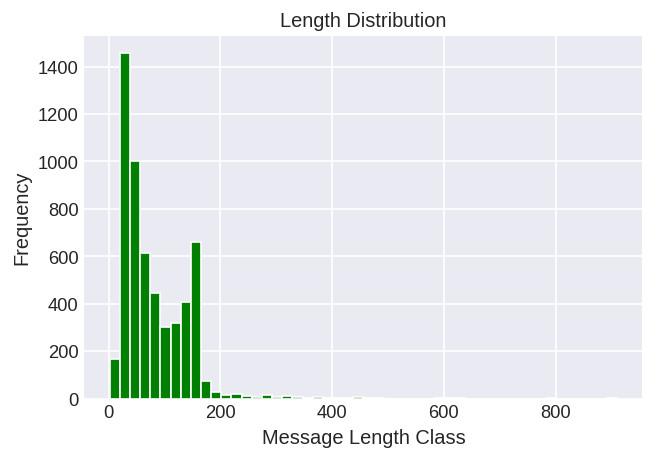

In [237]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(dpi = 120)
ax = plt.axes()
data['length'].plot(bins=50, kind='hist',ax=ax,color = 'green')
ax.set(xlabel = 'Message Length Class',ylabel = 'Frequency',title = 'Length Distribution');

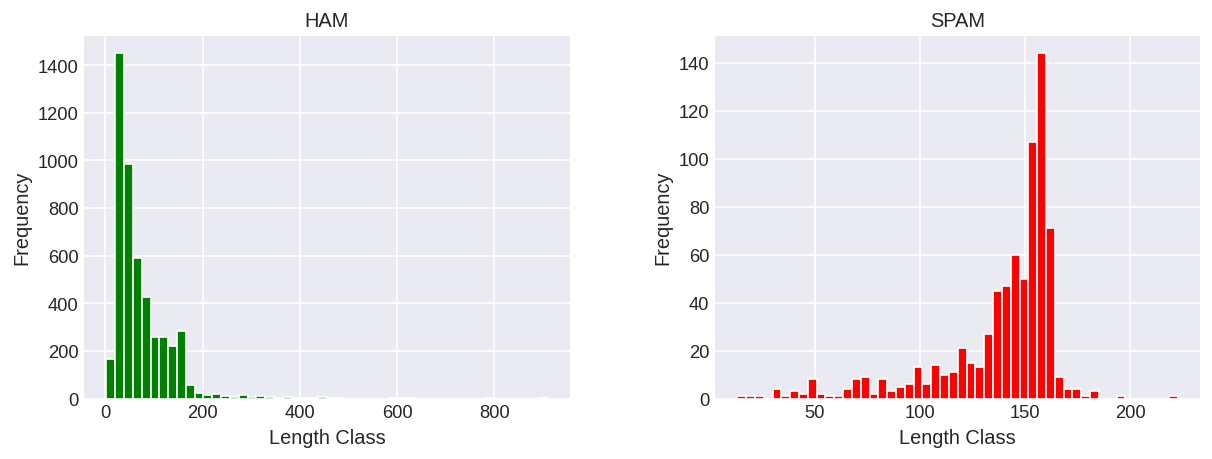

In [238]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

data[data['label']== 0 ].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'HAM')
data[data['label']== 1 ].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM');

Wiadomości typu SPAM mają zdecydowanie większą długość

 eliminacja znaków interpunkcyjnych z wiadomości i zamiana dużych liter na małe

In [239]:
def text_process(message):
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word.lower() for word in nopunc.split()]

In [240]:
data['text'] = data['text'].apply(text_process)

In [241]:
top_words = Counter(list(itertools.chain.from_iterable(data['text'])))

Najczęściej występujące słowa (top 16) w wiadomościach i różnice po podziale na klasy 

In [242]:
pd.DataFrame(top_words.most_common(16),  columns=['word', 'count'])

,word,count
0,to,2251
1,i,2239
2,you,2128
3,a,1442
4,the,1333
5,u,1132
6,and,971
7,is,893
8,in,888
9,me,791


In [243]:
top_words_ham = Counter(list(itertools.chain.from_iterable(data['text'][data.label == 1])))
pd.DataFrame(top_words_ham.most_common(16),  columns=['word', 'count'])

,word,count
0,to,689
1,a,378
2,call,347
3,you,287
4,your,263
5,free,216
6,the,204
7,for,203
8,now,189
9,or,188


In [244]:
top_words_spam = Counter(list(itertools.chain.from_iterable(data['text'][data.label == 0])))
pd.DataFrame(top_words_spam.most_common(16),  columns=['word', 'count'])

,word,count
0,i,2194
1,you,1841
2,to,1562
3,the,1129
4,a,1064
5,u,985
6,and,849
7,in,815
8,me,761
9,my,747


Występują różnice w ilości użytych słów w obu klasach.(pojedynczych wyrazów/stopwordsów)

In [245]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/justyna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Podział na tokeny i konwersja na lemmy

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [246]:
lemmitWordNet = lambda message : [lemmatizer.lemmatize(word) for word in message]
stemmitPS = lambda message : [stemmer.stem(word) for word in message]

In [247]:
data['lemmitWordNet'] = data['text'].apply(lemmitWordNet)
data['stemmitPS'] = data['text'].apply(stemmitPS)

Porównanie tokenów i lemm

In [248]:
samples = data.sample(n=8)
print([sample for sample in samples['lemmitWordNet']])
print('-----------'*50)
print([sample for sample in samples['stemmitPS']])

[['my', 'fri', 'ah', 'okie', 'lorgoin', '4', 'my', 'drivin', 'den', 'go', 'shoppin', 'after', 'tt'], ['he', 'said', 'that', 'he', 'had', 'a', 'right', 'giggle', 'when', 'he', 'saw', 'u', 'again', 'you', 'would', 'possibly', 'be', 'the', 'first', 'person2die', 'from', 'nvq', 'but', 'think', 'how', 'much', 'you', 'could', 'for'], ['ya', 'but', 'it', 'cant', 'display', 'internal', 'sub', 'so', 'i', 'gotta', 'extract', 'them'], ['one', 'of', 'the', 'joy', 'in', 'lifeis', 'waking', 'up', 'each', 'daywith', 'thought', 'that', 'somewheresomeone', 'care', 'enough', 'tosend', 'a', 'warm', 'morning', 'greeting'], ['got', 'what', 'it', 'take', '2', 'take', 'part', 'in', 'the', 'wrc', 'rally', 'in', 'oz', 'u', 'can', 'with', 'lucozade', 'energy', 'text', 'rally', 'le', 'to', '61200', '25p', 'see', 'pack', 'or', 'lucozadecoukwrc', 'itcould', 'be', 'u'], ['kkwhere', 'are', 'youhow', 'did', 'you', 'performed'], ['no', 'i', 'meant', 'the', 'calculation', 'is', 'the', 'same', 'that', 'ltgt', 'unit', 'a

W wygenerowanych wiadomosciach warto zwrócić uwagę na końcówki słów (fleksje)

Usunięcie słów o małym znaczeniu

In [249]:
def remove_stopwords(message):
    STOPWORDS = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    return [word for word in message if word not in STOPWORDS]

In [250]:
data['lemmitWordNet'] = data['lemmitWordNet'].apply(remove_stopwords)

In [251]:
top_words_ham = Counter(list(itertools.chain.from_iterable(data['lemmitWordNet'][data.label == 0])))
pd.DataFrame(top_words_ham.most_common(16),  columns=['word', 'count'])

,word,count
0,get,314
1,go,276
2,ltgt,276
3,ok,273
4,come,245
5,call,243
6,know,241
7,ill,238
8,like,234
9,got,232


In [252]:
top_words_spam = Counter(list(itertools.chain.from_iterable(data['lemmitWordNet'][data.label == 1])))
pd.DataFrame(top_words_spam.most_common(16),  columns=['word', 'count'])

,word,count
0,call,359
1,free,216
2,txt,150
3,text,137
4,mobile,135
5,claim,115
6,stop,115
7,reply,102
8,prize,94
9,get,83


In [253]:
data

,label,text,length,lemmitWordNet,stemmitPS
0,1.0,"[free, entry, in, 2, a, wkly, comp, to, win, f...",155,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, in, 2, a, wkli, comp, to, win, f..."
1,1.0,"[freemsg, hey, there, darling, its, been, 3, w...",147,"[freemsg, hey, darling, 3, week, word, back, i...","[freemsg, hey, there, darl, it, been, 3, week,..."
2,1.0,"[winner, as, a, valued, network, customer, you...",157,"[winner, valued, network, customer, selected, ...","[winner, as, a, valu, network, custom, you, ha..."
3,1.0,"[had, your, mobile, 11, months, or, more, u, r...",154,"[mobile, 11, month, r, entitled, update, lates...","[had, your, mobil, 11, month, or, more, u, r, ..."
4,1.0,"[six, chances, to, win, cash, from, 100, to, 2...",136,"[six, chance, win, cash, 100, 20000, pound, tx...","[six, chanc, to, win, cash, from, 100, to, 200..."
...,...,...,...,...,...
4822,0.0,"[huh, y, lei]",12,"[huh, lei]","[huh, y, lei]"
4823,0.0,"[will, ü, b, going, to, esplanade, fr, home]",36,"[ü, b, going, esplanade, fr, home]","[will, ü, b, go, to, esplanad, fr, home]"
4824,0.0,"[pity, was, in, mood, for, that, soany, other,...",57,"[pity, wa, mood, soany, suggestion]","[piti, wa, in, mood, for, that, soani, other, ..."
4825,0.0,"[the, guy, did, some, bitching, but, i, acted,...",125,"[guy, bitching, acted, like, id, interested, b...","[the, guy, did, some, bitch, but, i, act, like..."


In [254]:
X = data['lemmitWordNet']
Y = data.label

## Naive Bayes

Podział na dane testowe i treningowe

In [255]:
Y.shape
X.shape

(5574,)

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=20)

Implementacja i nauka klasyfikatora.

In [257]:
def dummy(doc):
    return doc

pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1),
                                 preprocessor=<function dummy at 0x7f6623186d90>,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function dummy at 0x7f6623186d90>,
                                 vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 Multinomia

In [258]:
y_pred = pipe.predict(X_test)

Score i matrix

In [259]:
metrics.accuracy_score(y_test, y_pred)

0.9598278335724534

In [260]:
ab = metrics.accuracy_score(y_test, y_pred)

In [261]:
confusion_m = metrics.confusion_matrix(y_test, y_pred)
confusion_m 

array([[1200,    0],
       [  56,  138]])

In [262]:
y_pred_proba = pipe.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.90948347, 0.00499582, 0.01094263, ..., 0.02997598, 0.00177925,
       0.00256784])

In [263]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9855111683848797


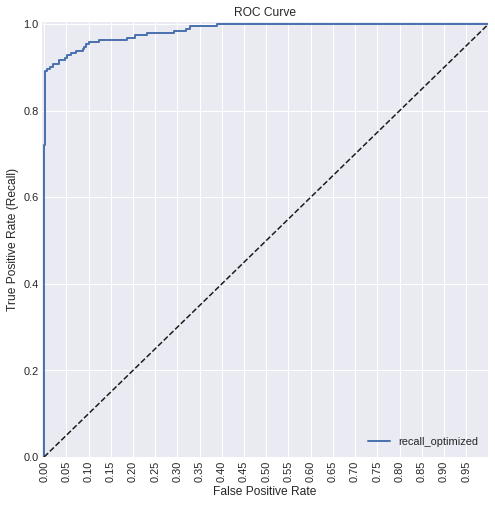

In [264]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_pred_proba)
print(metrics.auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

## Optymalizacja

In [267]:
def NWbias(alpha):
    global dummy 
    global X_train,y_train,y_test
    
    pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),
                     ('model', MultinomialNB(alpha=alpha))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    metrics.accuracy_score(y_test, y_pred)
    FP = cnf_matrix[0,1]
    return FP

In [268]:
a = scipy.optimize.minimize_scalar(NWbias, method = "bounded", bounds = (0,20))

In [269]:
a['x']

19.99999335625205

In [270]:
NWbias(a['x'])

0

In [271]:
pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),   
             ('model', MultinomialNB(alpha=a['x']))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9583931133428981

In [272]:
cnf_matrix

array([[1200,    0],
       [  58,  136]])

## Dummy Classifier

In [273]:
from sklearn.dummy import DummyClassifier

In [274]:
pipe_dummy = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', DummyClassifier())])
pipe_dummy.fit(X_train, y_train)

/home/justyna/.local/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1),
                                 preprocessor=<function dummy at 0x7f6623186d90>,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function dummy at 0x7f6623186d90>,
                                 vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 DummyClass

In [275]:
y_pred_class = pipe_dummy.predict(X_test)

In [276]:
metrics.accuracy_score(y_test, y_pred_class)

0.7625538020086083

In [277]:
ad = metrics.accuracy_score(y_test, y_pred_class)

In [278]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[1047,  153],
       [ 178,   16]])

In [279]:
cm_ad = metrics.confusion_matrix(y_test, y_pred_class)

Porównanie wyników (accuracy i confusion matrix) Naive Bayes z DummyClassifier

In [283]:
accur = {
    'Naive Bayes':  [ab],
        'Dummy Classifier': [ad]}

df = pd.DataFrame (accur, columns = ['Naive Bayes','Dummy Classifier'])
df

,Naive Bayes,Dummy Classifier
0,0.959828,0.762554


In [285]:
print('Confusion matrix for Dummy Classifier')
print(cm_ad)
print("Confusion matrix for Naive Bayes")
print(cnf_matrix)

Confusion matrix for Dummy Classifier
[[1047  153]
 [ 178   16]]
Confusion matrix for Naive Bayes
[[1200    0]
 [  58  136]]


# Klasyfikacja e-mail

In [223]:
mail = """Dear Sir:
I have been requested by the Nigerian National Petroleum Company to contact you for assistance in resolving a matter. The Nigerian National Petroleum Company has recently concluded a large number of contracts for oil exploration in the sub-Sahara region. The contracts have immediately produced moneys equaling US$40,000,000. The Nigerian National Petroleum Company is desirous of oil exploration in other parts of the world, however, because of certain regulations of the Nigerian Government, it is unable to move these funds to another region.
You assistance is requested as a non-Nigerian citizen to assist the Nigerian National Petroleum Company, and also the Central Bank of Nigeria, in moving these funds out of Nigeria. If the funds can be transferred to your name, in your United States account, then you can forward the funds as directed by the Nigerian National Petroleum Company. In exchange for your accommodating services, the Nigerian National Petroleum Company would agree to allow you to retain 10%, or US$4 million of this amount.
However, to be a legitimate transferee of these moneys according to Nigerian law, you must presently be a depositor of at least US$100,000 in a Nigerian bank which is regulated by the Central Bank of Nigeria.
If it will be possible for you to assist us, we would be most grateful. We suggest that you meet with us in person in Lagos, and that during your visit I introduce you to the representatives of the Nigerian National Petroleum Company, as well as with certain officials of the Central Bank of Nigeria.
Please call me at your earliest convenience at 18-467-4975. Time is of the essence in this matter; very quickly the Nigerian Government will realize that the Central Bank is maintaining this amount on deposit, and attempt to levy certain depository taxes on it.
Yours truly,
Prince Alyusi Islassis"""

In [224]:
mail = text_process(mail)
mail = lemmitWordNet(mail)
mail = remove_stopwords(mail)

In [225]:
y_pred = pipe.predict([mail])
y_pred

array([0.])

Wartość 0 w tym przypadku oznacza normalną wiadomość 

Podany mail jest spamem, natomiast został sklasyfikowany jako powiadomienie od uzytkownika ponieważ ma znacznie więcej znaków niż powiadomienia typu SPAM oraz styl wypowiedzi znacząco różni się od tych w danych treningowych. 

Niepoprawna klasyfikacja jest przyczyną analizowania wypowiedzi mailowej, przez klasyfikator wyuczony na wiadomościach typu SMS, które znacząco różnią się formą.